--- Analyse Préliminaire des Variables ---

--- Génération de la Matrice de Corrélation ---


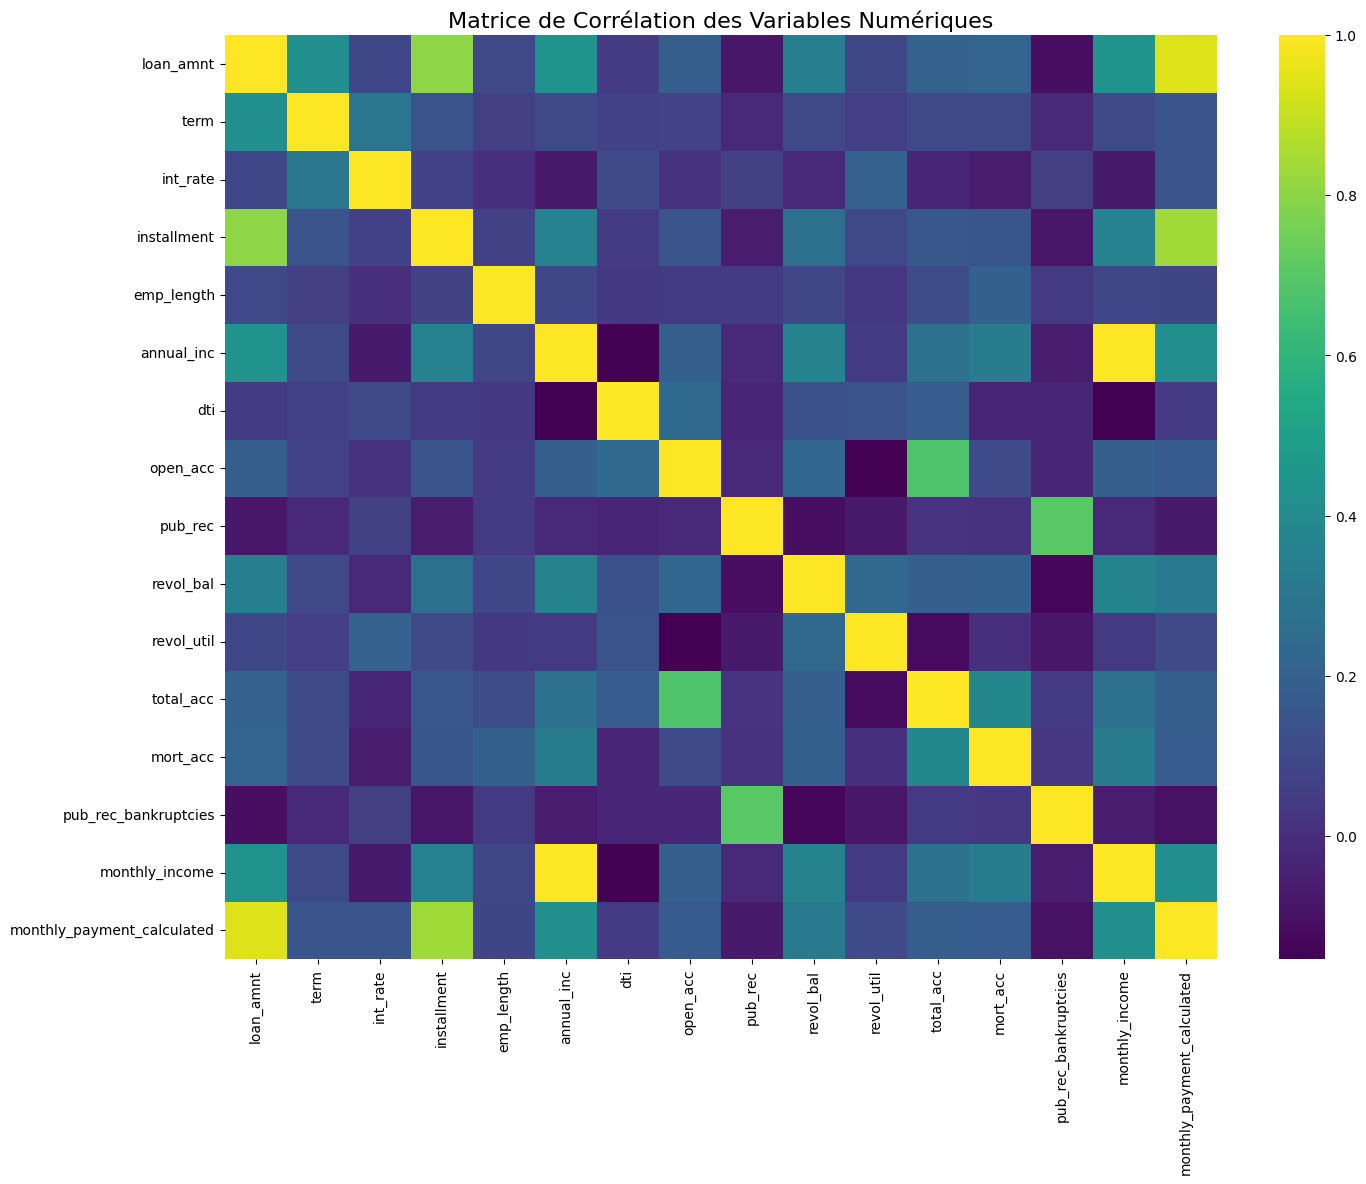


--- Calcul de l'Importance des Variables pour prédire le Défaut ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 70550, number of negative: 295664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2073
[LightGBM] [Info] Number of data points in the train set: 366214, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192647 -> initscore=-1.432902
[LightGBM] [Info] Start training from score -1.432902


<Figure size 1000x800 with 0 Axes>

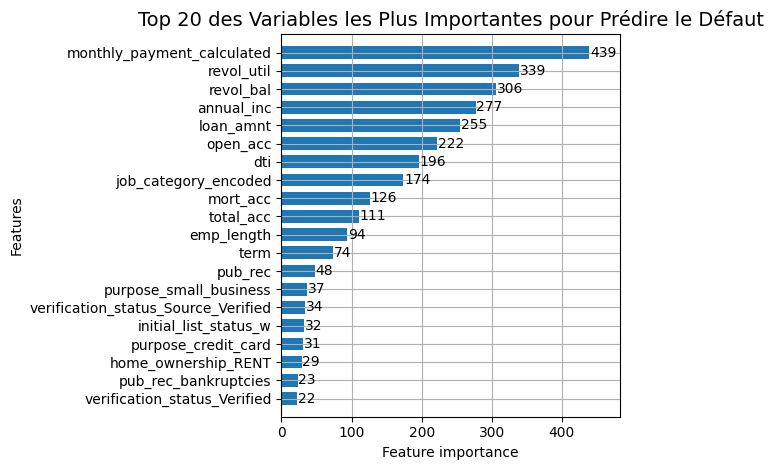


--- Sélection Finale de Variables ---
Les variables suivantes ont été sélectionnées pour la construction des modèles :
['term', 'annual_inc', 'dti', 'revol_util', 'revol_bal', 'loan_amnt', 'emp_length', 'home_ownership', 'purpose', 'verification_status', 'mort_acc', 'pub_rec', 'open_acc', 'total_acc']


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

# --- 1. Chargement et Préparation des Données ---
print("--- Analyse Préliminaire des Variables ---")
input_path = "../../data/processed/dataset_clean_no_outliers.parquet"
df = pd.read_parquet(input_path)

# Création de la variable cible binaire pour le risque de défaut
df['is_default'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)


# --- 2. Analyse de Corrélation des Variables Numériques ---
print("\n--- Génération de la Matrice de Corrélation ---")

# Sélection des colonnes numériques pertinentes
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# Exclure les identifiants et les codes catégoriels qui ne sont pas de vraies mesures
cols_to_exclude_corr = ['id', 'is_default', 'job_category_encoded', 'csp_category_encoded']
numerical_cols_for_corr = [col for col in numerical_cols if col not in cols_to_exclude_corr]

# Calcul de la matrice de corrélation
correlation_matrix = df[numerical_cols_for_corr].corr()

# Affichage de la heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='viridis', annot=False)
plt.title("Matrice de Corrélation des Variables Numériques", fontsize=16)
plt.show()


# --- 3. Analyse de l'Importance des Variables (Feature Importance) ---
# C'est la méthode la plus efficace pour sélectionner les variables.
# On entraîne un modèle rapide pour qu'il nous dise quelles variables sont les plus utiles.
print("\n--- Calcul de l'Importance des Variables pour prédire le Défaut ---")

# Préparation des données pour le modèle "scout"
features_to_exclude_model = [
    'loan_status', 'is_default', 'id', 'grade', 'sub_grade', 'int_rate', 'installment', 'last_pymnt_d',
    'emp_title', 'emp_title_clean', 'title', 'zip_code', 'job_category', 'csp_category', 
    'issue_d', 'earliest_cr_line'
]
X = df.drop(columns=features_to_exclude_model, errors='ignore')
X = pd.get_dummies(X, drop_first=True, dtype=float)
y = df['is_default']

# Entraînement d'un modèle LightGBM rapide
scout_model = lgb.LGBMClassifier(random_state=42)
scout_model.fit(X, y)

# Affichage du graphique d'importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(scout_model, max_num_features=20, height=0.7)
plt.title("Top 20 des Variables les Plus Importantes pour Prédire le Défaut", fontsize=14)
plt.tight_layout()
plt.show()


# --- 4. Sélection Finale des Variables ---
# Sur la base du graphique ci-dessus, on sélectionne nos "championnes"
selected_features = [
    'term',
    'annual_inc',
    'dti',
    'revol_util',
    'revol_bal',
    'loan_amnt',
    'emp_length',
    'home_ownership',
    'purpose',
    'verification_status',
    'mort_acc',
    'pub_rec',
    'open_acc',
    'total_acc'
]
print("\n--- Sélection Finale de Variables ---")
print("Les variables suivantes ont été sélectionnées pour la construction des modèles :")
print(selected_features)

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

print("\n" + "="*50)
print("### Phase d'Analyse de Dépendance (ANOVA) ###")
print("="*50)

# On s'assure que df est bien chargé et préparé
# df = pd.read_parquet("../../data/processed/dataset_clean_no_outliers.parquet")

# --- Test ANOVA 1 : Taux d'intérêt en fonction du Grade ---
# On s'attend à une très forte dépendance ici. C'est un bon test de validation.
print("\n--- Test 1 : int_rate ~ grade ---")

# Création du modèle statistique
# La formule 'int_rate ~ C(grade)' teste l'influence de la catégorie 'grade' sur 'int_rate'
model_grade = ols('int_rate ~ C(grade)', data=df).fit()

# Calcul de la table ANOVA
anova_table_grade = sm.stats.anova_lm(model_grade, typ=2)

# Affichage des résultats
print(anova_table_grade)

# Interprétation
p_value_grade = anova_table_grade["PR(>F)"][0]
if p_value_grade < 0.05:
    print(f"✅ Conclusion : Le 'grade' a un impact statistiquement très significatif sur le taux d'intérêt (p-value = {p_value_grade:.3e}).")
else:
    print("❌ Conclusion : Le 'grade' ne semble pas avoir d'impact significatif.")


# --- Test ANOVA 2 : Taux d'intérêt en fonction du Motif du prêt (Purpose) ---
print("\n--- Test 2 : int_rate ~ purpose ---")

model_purpose = ols('int_rate ~ C(purpose)', data=df).fit()
anova_table_purpose = sm.stats.anova_lm(model_purpose, typ=2)

print(anova_table_purpose)

p_value_purpose = anova_table_purpose["PR(>F)"][0]
if p_value_purpose < 0.05:
    print(f"✅ Conclusion : Le 'purpose' a un impact statistiquement significatif sur le taux d'intérêt (p-value = {p_value_purpose:.3e}).")
else:
    print("❌ Conclusion : Le 'purpose' ne semble pas avoir d'impact significatif.")


# --- Test ANOVA 3 : Taux d'intérêt en fonction du Type de propriété (Home Ownership) ---
print("\n--- Test 3 : int_rate ~ home_ownership ---")

model_ownership = ols('int_rate ~ C(home_ownership)', data=df).fit()
anova_table_ownership = sm.stats.anova_lm(model_ownership, typ=2)

print(anova_table_ownership)

p_value_ownership = anova_table_ownership["PR(>F)"][0]
if p_value_ownership < 0.05:
    print(f"✅ Conclusion : Le 'home_ownership' a un impact statistiquement significatif sur le taux d'intérêt (p-value = {p_value_ownership:.3e}).")
else:
    print("❌ Conclusion : Le 'home_ownership' ne semble pas avoir d'impact significatif.")


### Phase d'Analyse de Dépendance (ANOVA) ###

--- Test 1 : int_rate ~ grade ---
                sum_sq        df             F  PR(>F)
C(grade)  5.320903e+06       6.0  68365.413368     0.0
Residual  4.750336e+06  366207.0           NaN     NaN
✅ Conclusion : Le 'grade' a un impact statistiquement très significatif sur le taux d'intérêt (p-value = 0.000e+00).

--- Test 2 : int_rate ~ purpose ---


C:\Users\Pierre\AppData\Local\Temp\ipykernel_30024\1370145110.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_grade = anova_table_grade["PR(>F)"][0]


                  sum_sq        df           F  PR(>F)
C(purpose)  1.818988e+05      13.0  518.128574     0.0
Residual    9.889340e+06  366200.0         NaN     NaN
✅ Conclusion : Le 'purpose' a un impact statistiquement significatif sur le taux d'intérêt (p-value = 0.000e+00).

--- Test 3 : int_rate ~ home_ownership ---


C:\Users\Pierre\AppData\Local\Temp\ipykernel_30024\1370145110.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_purpose = anova_table_purpose["PR(>F)"][0]


                         sum_sq        df           F  PR(>F)
C(home_ownership)  4.189187e+04       5.0  305.924957     0.0
Residual           1.002935e+07  366208.0         NaN     NaN
✅ Conclusion : Le 'home_ownership' a un impact statistiquement significatif sur le taux d'intérêt (p-value = 0.000e+00).


C:\Users\Pierre\AppData\Local\Temp\ipykernel_30024\1370145110.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value_ownership = anova_table_ownership["PR(>F)"][0]
